<a href="https://colab.research.google.com/github/Nishaanth4969/pytorch-vggnet16/blob/main/Vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [24]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [41]:
import os
def dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
dir('/content/drive/MyDrive/tumor')

There are 3 directories and 1 images in '/content/drive/MyDrive/tumor'.
There are 0 directories and 501 images in '/content/drive/MyDrive/tumor/TRAIN'.
There are 0 directories and 202 images in '/content/drive/MyDrive/tumor/VAL'.
There are 0 directories and 100 images in '/content/drive/MyDrive/tumor/TEST'.


In [44]:
train_data = datasets.ImageFolder(root='/content/drive/MyDrive/marvel/train',
                                     transform=train_transform)
test_data = datasets.ImageFolder(root='/content/drive/MyDrive/marvel/valid', 
                                    transform=test_transform)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 644
    Root location: /content/drive/MyDrive/marvel/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 112
    Root location: /content/drive/MyDrive/marvel/valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [5]:
class_names = train_data.classes
class_names

['black widow', 'captain america']

In [28]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=32, 
                              num_workers=os.cpu_count(), 
                              shuffle=True) 

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=32, 
                             num_workers=os.cpu_count(), 
                             shuffle=False) 

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fa8cb3f7c10>,
 <torch.utils.data.dataloader.DataLoader at 0x7fa8cb3f7b20>)

In [29]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [47]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=2):
        super(VGGNet, self).__init__()
        
        self.features = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [9]:
!pip install torchinfo
import torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
from torchinfo import summary
model0 = VGGNet(num_classes=2)
summary(model0, input_size=(1, 3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
VGGNet                                   [1, 1]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         128
│    └─ReLU: 2-3                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-4                       [1, 64, 224, 224]         36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 224, 224]         128
│    └─ReLU: 2-6                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-7                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 112, 112]        256
│    └─ReLU: 2-10                        [1, 128, 112, 112]        --
│    └─Conv2d: 2-11                      [1, 128, 112, 112]        147,

In [11]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
  
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [12]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
  
    model.eval() 
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():

        for batch, (X, y) in enumerate(dataloader):
    
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [45]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.BCELoss(),
          epochs: int = 5):
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [15]:
NUM_EPOCHS = 2

model0 = VGGNet(num_classes=2)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.0013)


model_0_results = train(model=model0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0062 | train_acc: 0.5259 | test_loss: 0.6905 | test_acc: 0.5703
Epoch: 2 | train_loss: 0.6959 | train_acc: 0.5000 | test_loss: 0.6917 | test_acc: 0.5703


In [35]:
model_0_results.keys()
from typing import Dict, List

In [36]:
def plot_loss_curves(results: Dict[str, List[float]]):

    
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

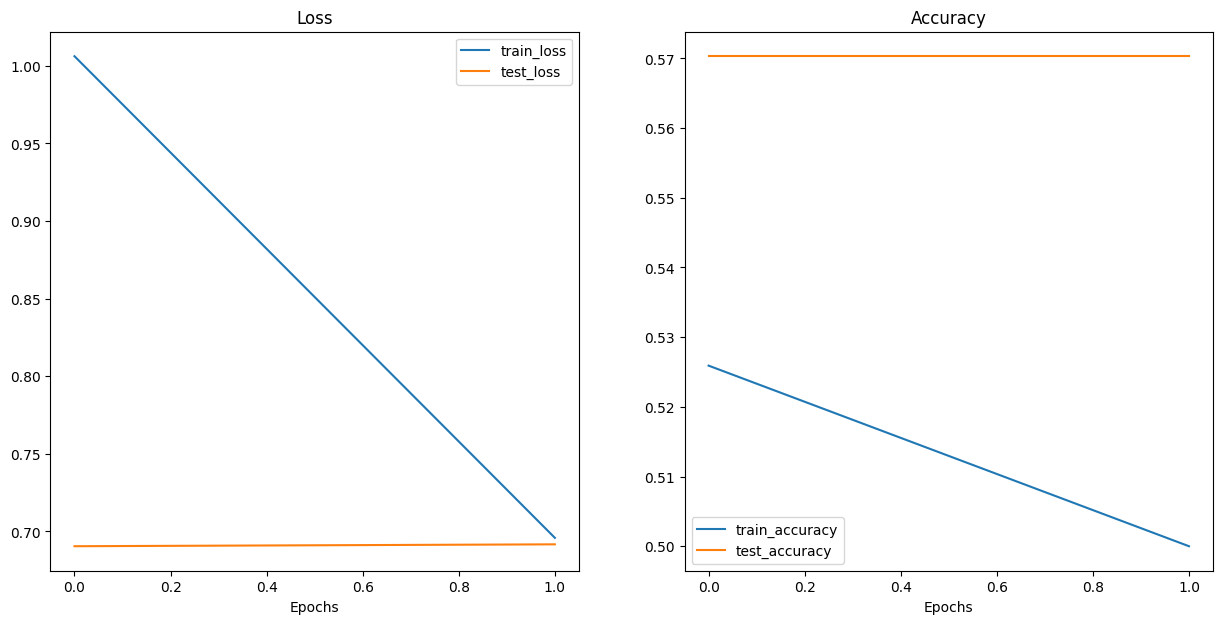

In [37]:
plot_loss_curves(model_0_results)

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model0.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model0(images)
        predictions = torch.sigmoid(outputs) > 0.5
        y_true += labels.cpu().numpy().tolist()
        y_pred += predictions.cpu().numpy().tolist()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

Precision: 0.5089, Recall: 1.0000, F1-score: 0.6746
